In [1]:
import chess
import chess.pgn
import numpy as np
import pandas as pd
import pickle
from collections import Counter
from tqdm import tqdm

In [2]:
import os
from IPython.display import display, clear_output
import time

In [3]:
class ChessGame:
    game_processed = False
    
    def __init__(self, game):
        self.chessdotGame = game
        self.moves = []
        self.board = chess.Board()
        self.url = game.headers['Site']
        self.white_id = game.headers['White']
        self.black_id = game.headers['Black']
        self.white_elo = int(game.headers['WhiteElo']) #+ int(game.headers['WhiteRatingDiff'])
        self.black_elo = int(game.headers['BlackElo']) #+ int(game.headers['BlackRatingDiff'])
        self.game_result = game.headers['Result']
        self.time_control = self.time_control_to_list(game.headers['TimeControl'])
        self.clock_situation = [self.time_control[0]]*2
        self.total_ply = len(list(game.mainline_moves()))
        self.game_state = 0.6
        self.pos_eval = 30
        node = self.chessdotGame
        
        while not self.game_processed:
            try:
                node = node.next()
                move_dict = self.process_game(node)
                self.moves.append(ChessMove(move_dict))
            except:
                self.game_processed = True

    def time_control_to_list(self, time_control_obj):
        time_control = [float(x) for x in time_control_obj.split('+')]
        time_control += [0] * (2 - len(time_control))
        return time_control
    
    def povscore_to_int(self, eval, turn):
        eval_type = str(eval).split('(')[-2].split(')')[0]
        if eval_type == 'Cp':
            evaluation = int(str(eval).split('(')[-1].split(')')[0])
        else:
            sign = str(eval).split('(')[-1].split(')')[0][0]
            evaluation = int(sign + '6400')
        return evaluation*(-1)**(turn)

    def eval_to_game_state(self, value, cuts = [np.inf, 375, 250, 150, 75, 25, -25, -75, -150, -250, -375, -np.inf]):
        if abs(self.pos_eval - value) < 20:
            return self.game_state
        for i in range(len(cuts) - 1):
            if cuts[i] >= value > cuts[i + 1]:
                return 1-i/10

    def get_eval_from_result(self):
        if self.game_result == '1-0':
            return 6400
        elif self.game_result == '0-1':
            return -6400
        else:
            return 0

    def time_spent_category(self, move_time, threshold_fast=1/30, threshold_slow=1/6):
        total_time = self.time_control[0]
        fast_move = total_time*threshold_fast
        slow_move = total_time*threshold_slow
        if self.time_control[1] > 0:
            fast_move += self.time_control[1]
            slow_move += self.time_control[1]
        if move_time == 0:
            return 'instant'
        elif move_time <= fast_move:
            return 'fast'
        elif move_time > slow_move:
            return 'slow'
        else:
            return 'normal'
    
    def process_game(self, node):
        move_dict = {}
        move_dict['ply_count'] = node.ply()
        move_dict['move_color'] = not node.turn()
        
        try:
            eval = node.eval()
            move_dict['move_evaluation'] = self.povscore_to_int(node.eval(), move_dict['move_color'])
        except:
            move_dict['move_evaluation'] = self.get_eval_from_result()
        post_move_gamestate = self.eval_to_game_state(move_dict['move_evaluation'])
        move_dict['game_state'] = post_move_gamestate
        move_dict['game_state_change'] = post_move_gamestate - self.game_state
        self.pos_eval = move_dict['move_evaluation']
        self.game_state = post_move_gamestate
        
        move_dict['time_left'] = node.clock()
        move_dict['time_trouble'] = move_dict['time_left'] * 10 < self.time_control[0]
        move_dict['move_increment'] = self.time_control[1]
        move_dict['time_spent'] = self.clock_situation[move_dict['move_color']] + move_dict['move_increment'] - move_dict['time_left']
        move_dict['time_category'] = self.time_spent_category(move_dict['time_spent'])
        self.clock_situation[int(move_dict['move_color'])] = move_dict['time_left']
        move_dict['opponent_clock'] = self.clock_situation[node.turn()]
        move_dict['can_start_flagging'] = move_dict['opponent_clock'] < 15 and move_dict['move_increment'] < 1
        move_dict['move_uci'] = node.uci()
        move_dict['pre_board_state'] = self.board.fen()
        self.board.push(chess.Move.from_uci(move_dict['move_uci']))
        return move_dict

In [4]:
class ChessMove:
    cur_board_state = None
    
    def __init__(self, move_dict):
        fen = move_dict['pre_board_state']
        uci = move_dict['move_uci']
        self.pre_board_state = fen
        self.uci_notation = uci
        self.chessdotMove = chess.Move.from_uci(uci)
        self.chessdotBoard = chess.Board(fen=self.pre_board_state)
        self.san_notation = self.chessdotBoard.san(self.chessdotMove)
        if self.cur_board_state is None:
            self.cur_board_state = fen
        self.apply_move()

        
        #External Factors
        self.ply_count = move_dict['ply_count']
        self.move_count = (1+self.ply_count)//2
        self.color = move_dict['move_color']
        self.increment = move_dict['move_increment']
        self.has_increment = self.increment != 0
        self.in_time_trouble = move_dict['time_trouble']
        self.can_dirty_flag = move_dict['can_start_flagging']
        self.time_spent = move_dict['time_spent']
        self.time_category = move_dict['time_category']
        self.self_clock = move_dict['time_left']
        self.opponent_clock = move_dict['opponent_clock']
        self.centipawn_eval = move_dict['move_evaluation']
        self.game_state = move_dict['game_state']
        self.delta_game_state = move_dict['game_state_change']
        self.is_endgame = self.is_endgame()
        classification = self.determine_move_quality()
        self.classification = classification[1]
        self.classification_name = classification[0]
        
        #Piece Characteristics
        self.start_square = self.chessdotMove.from_square
        self.end_square = self.chessdotMove.to_square
        self.distance = chess.square_distance(self.start_square, self.end_square)
        self.piece = self.chessdotBoard.piece_at(self.start_square)
        self.piece_value = self.piece.piece_type
        
        
        #Move Characteristics
        self.is_check = self.chessdotBoard.gives_check(self.chessdotMove)
        check_set = chess.Board(self.cur_board_state).checkers().tolist()
        self.is_double_check = sum(check_set) > 1 and self.is_check
        self.is_discovered_check = self.is_check and (not check_set[self.end_square] or self.is_double_check)

        self.is_capture = self.chessdotBoard.is_capture(self.chessdotMove)
        self.captured_piece = self.chessdotBoard.piece_at(self.end_square)
        self.captured_piece_value = self.captured_piece.piece_type if self.captured_piece is not None else 0

        self.threats = self.get_prepare_capture()
        self.is_threat = len(self.threats) > 0
        
        self.is_developing = self.get_relative_position(self.start_square, self.end_square) > 0
        self.is_retreating = self.get_relative_position(self.start_square, self.end_square) < 0

        self.legal_moves = self.chessdotBoard.legal_moves
        self.count_legal_moves = len([move for move in self.legal_moves])
        self.count_force_moves = len([move for move in self.legal_moves if (self.chessdotBoard.is_capture(move) or self.chessdotBoard.gives_check(move))])
        self.force_moves_percent = self.count_force_moves / self.count_legal_moves
        
        #Move Interactions
        self.was_hanging = self.get_hanging_status(self.chessdotBoard, self.start_square, not self.color)
        self.is_hanging = self.get_hanging_status(self.apply_move(), self.end_square, not self.color)
        self.was_true_hanging = self.get_hanging_status(self.chessdotBoard, self.start_square, not self.color, True)
        self.is_true_hanging = self.get_hanging_status(self.apply_move(), self.end_square, not self.color, True)
        self.create_tension = self.get_prepare_capture('tension')
        self.resolve_tension = self.get_tension_change('resolve')
        self.maintain_tension = self.get_tension_change('maintain')
        self.is_create_tension =  (len(self.create_tension)) > 0
        self.is_resolve_tension =  (len(self.resolve_tension)) > 0
        self.is_maintain_tension =  (len(self.maintain_tension)) > 0
        

    def apply_move(self):
        board = chess.Board(fen=self.pre_board_state)
        board.push(self.chessdotMove)
        self.cur_board_state = board.fen()
        return board

    def get_square_attackers(self, board, square, color):
        return {sq: board.piece_at(sq).piece_type for sq in board.attackers(color, square)}

    def get_complete_influencers(self, influencers, target, board, color):

        def get_battery_influencers(square, target_square):
            ray = chess.SquareSet.ray(square, target_square)
            return ray
            
        complete_influencers = influencers.copy()
        
        for square in influencers:
            allies = []
            strip = get_battery_influencers(square, target)
            if len(strip) != 0:
                if chess.square_rank(target) == chess.square_rank(square) or chess.square_file(target) == chess.square_file(square):
                    allies = [chess.piece_symbol(chess.ROOK), chess.piece_symbol(chess.QUEEN)]
                else:
                    allies = [chess.piece_symbol(chess.BISHOP), chess.piece_symbol(chess.QUEEN)]
            else:
                continue
            backups = [s for s in strip if s > square] if square > target else [s for s in strip if s < square]
            backups = sorted(backups, key=lambda s: chess.square_distance(square, s))
            for sq in backups:
                if board.piece_at(sq) == None:
                    continue
                elif board.piece_at(sq).color != color:
                    break
                elif str(board.piece_at(sq)) in allies:
                    complete_influencers[sq] = board.piece_at(sq).piece_type
        return complete_influencers

    def get_relative_position(self, sq_start, sq_end):
        return (chess.square_rank(sq_start) - chess.square_rank(sq_end)) * (-1)**int(self.color)
    
    def get_prepare_capture(self, toret='attack'):
        board = self.apply_move()
        board.push(chess.Move.null())
        attacked_squares={}
        tension_squares={}
        for sq in board.attacks(self.end_square):
            if board.piece_at(sq) != None:
                if board.piece_at(sq).color == self.color:
                    continue
                target_value = board.piece_at(sq).piece_type
                attackers = self.get_square_attackers(board, sq, self.color)
                defenders = self.get_square_attackers(board, sq, not self.color)
                attacking_pieces = sorted([attackers[sq] for sq in attackers])
                defending_pieces = sorted([defenders[sq] for sq in defenders])

                all_attack = self.get_complete_influencers(attackers, sq, self.apply_move(), self.color)
                all_defend = self.get_complete_influencers(defenders, sq, self.apply_move(), not self.color)
                if set(all_attack) - set(attackers) != set():
                    for new_sq in set(all_attack) - set(attackers):
                        attacking_pieces.append(all_attack[new_sq])
                if set(all_defend) - set(defenders) != set():
                    for new_sq in set(all_defend) - set(defenders):
                        defending_pieces.append(all_defend[new_sq])
                if attacking_pieces[0] < target_value:
                    attacked_squares[sq] = target_value
                elif len(defending_pieces) == 0:
                    attacked_squares[sq] = target_value
                elif len(attacking_pieces) > len(defending_pieces):
                    for i, d in enumerate(defending_pieces):
                        if  d < attacking_pieces[i+1]:
                            tension_squares[sq] = target_value
                            break
                    attacked_squares[sq] = target_value
                elif len(attacking_pieces) > len(defending_pieces) or (attacking_pieces[0] < 5 and target_value > 1) or attacking_pieces[0] == 1:
                    tension_squares[sq] = target_value
        if toret == 'attack':
            #return sorted(attacked_squares, key=lambda s: attacked_squares[s], reverse=True)
            return set(attacked_squares)
        elif toret == 'tension':
            #return sorted(tension_squares, key=lambda s: tension_squares[s], reverse=True)
            return set(tension_squares)

    def get_hanging_status(self, board, square, color, true=False):
        attackers = self.get_square_attackers(board, square, color)
        defenders = self.get_square_attackers(board, square, not color)
        legal_attackers = self.get_legal_from_dict(board, square, attackers)
        if true:
            attackers = legal_attackers
        if attackers == {}:
            return False
        if sorted([attackers[sq] for sq in attackers])[0] < self.piece_value:
            return True
        elif len(attackers) > len(defenders):
            return True
        else:
            return False

    def get_legal_from_dict(self, board, square, sq_dict):
        board.turn = not self.color
        target = self.square_ind_to_name(square)
        moves = [self.square_ind_to_name(sq) + target for sq in sq_dict]
        mask = [board.is_legal(chess.Move.from_uci(move)) for move in moves]
        legal_sq_dict = {}
        for key, include in zip(sq_dict.keys(), mask):
            if include:
                legal_sq_dict[key] = sq_dict[key]
        return legal_sq_dict
        
    def get_tension_change(self, toret):
        def cap_relevant(target_move, board):
            target_square = target_move.to_square
            cappers = [move for move in board.legal_moves if board.is_capture(move) and move.to_square == target_square]
            cappers_type = sorted([board.piece_at(move.from_square).piece_type for move in cappers])
            try:
                capped = board.piece_at(target_square).piece_type
            except:
                capped = 1
            test_board = chess.Board(board.fen())
            test_board.push(target_move)
            if cappers_type[0] == 1:
                return True
            if self.get_hanging_status(test_board, target_move.to_square, board.turn):
                return capped > 1
            return False
        board = chess.Board(fen=self.pre_board_state)
        pre_captures = [move for move in board.legal_moves if board.is_capture(move)]
        pre_mask = [cap_relevant(move, board) for move in pre_captures]
        pre_captures = [move.to_square for move, include in zip(pre_captures, pre_mask) if include]
        board.push(self.chessdotMove)
        board.push(chess.Move.null())
        post_captures = [move for move in board.legal_moves if board.is_capture(move)]
        post_mask = [cap_relevant(move, board) for move in post_captures]
        post_captures = [move.to_square for move, include in zip(post_captures, post_mask) if include]
        pre_counts = Counter(pre_captures)
        post_counts = Counter(post_captures)
        created_squares = set([sq for sq in post_counts if post_counts[sq] > pre_counts[sq]])
        released_squares  = set([sq for sq in pre_counts if post_counts[sq] < pre_counts[sq]])
        maintained_squares = set([sq for sq in pre_captures if sq in post_captures])
        tension_squares = {
            'create': created_squares, #this includes tension plus attack
            'maintain': maintained_squares,
            'resolve': released_squares
        }
        return tension_squares[toret]
        
    def square_ind_to_name(self, square_ind):
        return chess.square_name(square_ind)

    def fen_to_material(self):
        board = chess.Board(self.cur_board_state)
        piece_count = {'K': 0, 'Q': 0, 'R': 0, 'B': 0, 'N': 0, 'P': 0,
                       'k': 0, 'q': 0, 'r': 0, 'b': 0, 'n': 0, 'p': 0}
        pawn_files = {'P': [], 'p': []}
    
        for square in chess.SQUARES:
            piece = board.piece_at(square)
            if piece is not None:
                piece_count[piece.symbol()] += 1
                if piece.piece_type == 1:
                    pawn_files[piece.symbol()].append(chess.square_file(square))
    
        for color in pawn_files:
            pawn_files[color].sort()
        
        return piece_count, pawn_files
    
    def is_endgame(self):
        piece_count, pawn_files = self.fen_to_material()
        total_material = (
            piece_count['Q'] + piece_count['R'] + piece_count['B'] + piece_count['N'] + 
            piece_count['q'] + piece_count['r'] + piece_count['b'] + piece_count['n']
        )
        return total_material < 6
    
    def fen_to_boardstate(self): #reservoir sampling for positions
        piece_count, pawn_files = self.fen_to_material()
        w = 1e4*piece_count['K'] + 1e3*piece_count['Q'] + 1e2*piece_count['R'] + 1e1*piece_count['B'] + 1e0*piece_count['N']
        w_pawn_file = float('0.'+''.join(map(str, pawn_files['P'])))
        b = 1e4*piece_count['k'] + 1e3*piece_count['q'] + 1e2*piece_count['r'] + 1e1*piece_count['b'] + 1e0*piece_count['n']
        b_pawn_file = float('0.'+''.join(map(str, pawn_files['p'])))
        return w+w_pawn_file, b+b_pawn_file

    def determine_move_quality(self):
        state_change = (-1)**int(self.color) * self.delta_game_state
        subjective_state = (-1)**int(not self.color) * self.game_state
        old_state = self.game_state - self.delta_game_state
        near_equality = abs(old_state) < .25 and abs(subjective_state) < .25
        decisive_advantage = abs(old_state) > .35 or abs(subjective_state) > .35
        fate_sealed = abs(old_state) == 1 or abs(subjective_state) == 1
        if state_change < .05 and subjective_state > 0:
            return 'Great', 1
        elif state_change < .15:
            return 'Good', 2
        elif (state_change < .25 and not decisive_advantage) or (state_change < .35 and near_equality):
            return 'Inaccuracy', 3
        elif state_change > .45 or (state_change > .35 and decisive_advantage) or (state_change > .25 and fate_sealed):
            return 'Blunder', 5
        else:
            return 'Mistake', 4

In [5]:
def load_pgns(file_path, num_games=None, start_index=0, encoding="utf-8"):
    games = []
    with open(file_path, "r", encoding=encoding) as file:
        for _ in tqdm(range(start_index), desc='Skipping games', unit='game', leave=False):
            game = chess.pgn.read_game(file)
            if game is None:
                break
        for _ in tqdm(range(num_games), desc='Loading games', unit='game', leave=True) if num_games else iter(int, 1):
            game = chess.pgn.read_game(file)
            if game is None:
                break
            games.append(game)
    return games

def animate_game(game, animate=True):
    board = chess.Board()
    moves = game.moves
    for move in moves:
        board.push(move.chessdotMove)
        if animate:
            time.sleep(.1)
            clear_output(wait=True)
            display(board)
            print(str(move.move_count)+'.', move.san_notation)
            print('GameState:', move.game_state)
            print('MoveQuality:', move.classification)

def save_games_to_file(games, file_path):
    with open(file_path, 'wb') as file:
        pickle.dump(games, file)

def load_games_from_file(file_path):
    if os.path.exists(file_path):
        print('loading games from cache...')
        with open(file_path, 'rb') as file:
            games = pickle.load(file)
        return games
    else:
        return None

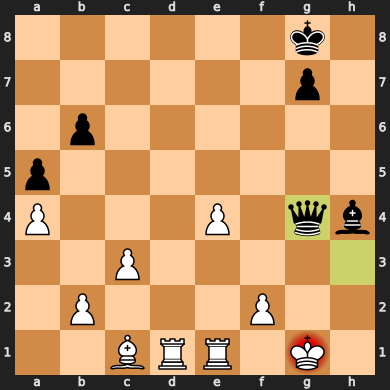

30. Qg4+
GameState: 0.5
MoveQuality: 2


In [6]:
games = None
assets_path = os.path.join(os.path.dirname(os.getcwd()), 'test_asset')
#cached_games_path = os.path.join(assets_path, 'games.pkl')
#games = load_games_from_file(cached_games_path)
if games is None:
    #single_path = os.path.join(assets_path, 'Jimbobo_games.pgn')
    single_path = os.path.join(assets_path, 'fabdub.pgn')
    #games = load_pgns(single_path, 825)
    games = load_pgns(single_path, 1)
    #save_games_to_file(games, cached_games_path)
game = ChessGame(games[0])
animate_game(game)

In [7]:
print(game.url)
print(game.game_result)
print('White({}): {}'.format(game.white_elo, game.white_id))
print('Black({}): {}'.format(game.black_elo, game.black_id))
for move in game.moves:
    if move.color:
        dots = '.'
    else:
        dots = '...'   
    print('{}{}{}, GameState: {}, MoveQuality: {}'.format(move.move_count, dots, move.san_notation, move.game_state, move.classification_name))
    print(move.threats, move.create_tension, move.resolve_tension, move.maintain_tension)

Samarkand, Uzbekistan
0-1
White(2815): Caruana, Fabiano
Black(2763): Dubov, Daniil
1.e4, GameState: 0.6, MoveQuality: Great
set() set() set() set()
1...e5, GameState: 0.6, MoveQuality: Good
set() set() set() set()
2.Nf3, GameState: 0.6, MoveQuality: Great
{36} set() set() set()
2...Nc6, GameState: 0.6, MoveQuality: Good
set() set() set() set()
3.Bc4, GameState: 0.6, MoveQuality: Great
set() set() set() set()
3...Nf6, GameState: 0.6, MoveQuality: Good
{28} set() set() set()
4.d3, GameState: 0.6, MoveQuality: Great
set() set() set() set()
4...Be7, GameState: 0.6, MoveQuality: Good
set() set() set() set()
5.O-O, GameState: 0.6, MoveQuality: Great
set() set() set() set()
5...O-O, GameState: 0.6, MoveQuality: Good
set() set() set() set()
6.Re1, GameState: 0.6, MoveQuality: Great
set() set() set() set()
6...d6, GameState: 0.6, MoveQuality: Good
set() set() set() set()
7.a4, GameState: 0.6, MoveQuality: Great
set() set() set() set()
7...Be6, GameState: 0.6, MoveQuality: Good
set() {26} set() 

Nf3


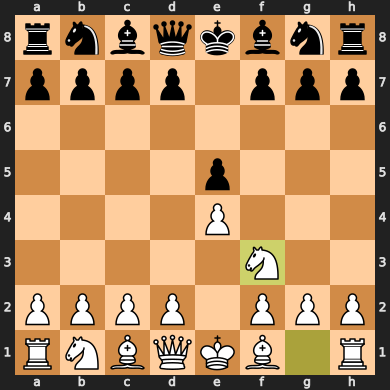

Nf6


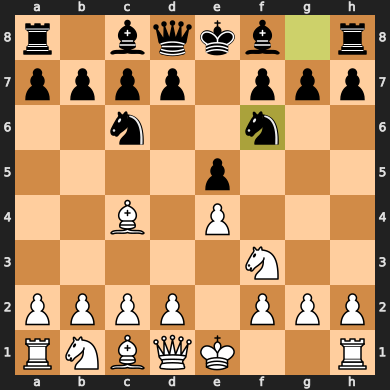

Qb3


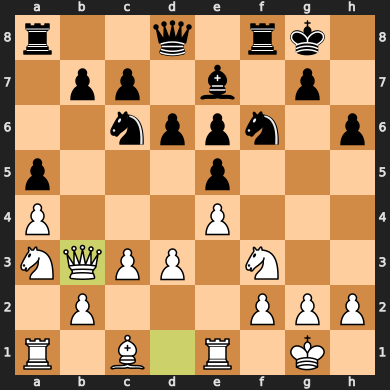

Be3


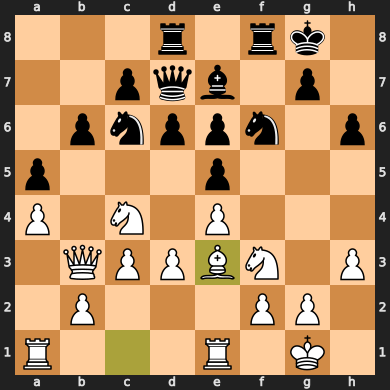

Nxc7


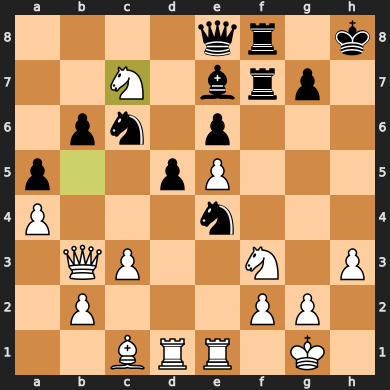

Qc8


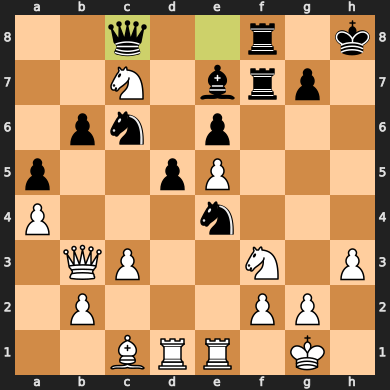

Nxe6


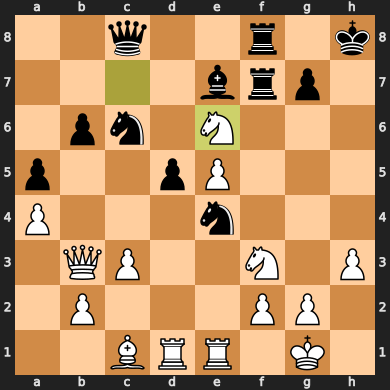

Rxf3


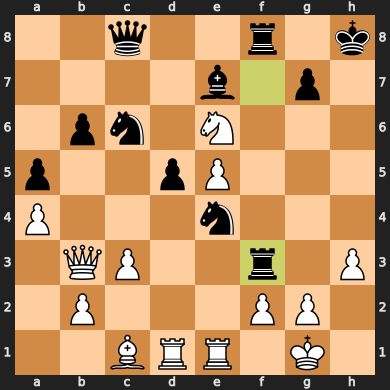

gxf3


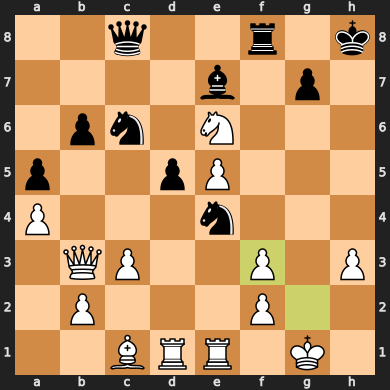

Nxe5


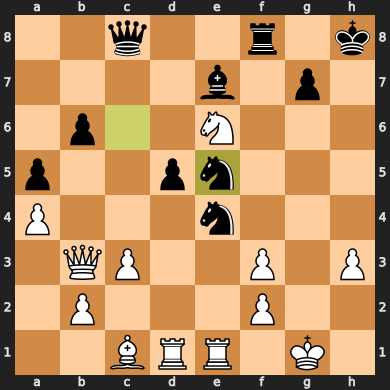

Qxh3


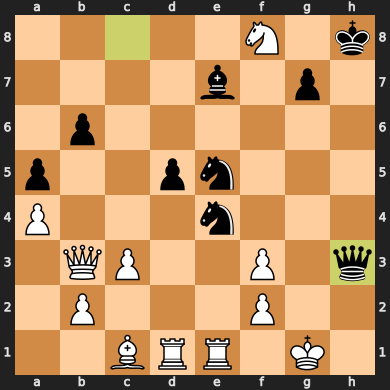

Ng6+


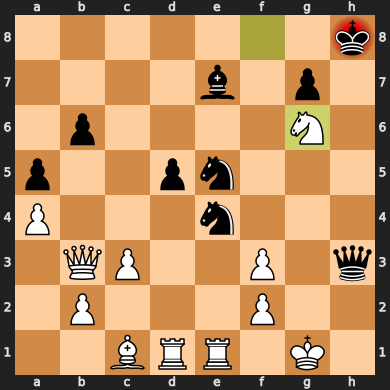

Qxd5


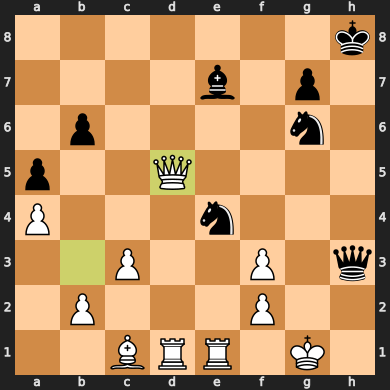

Nh4


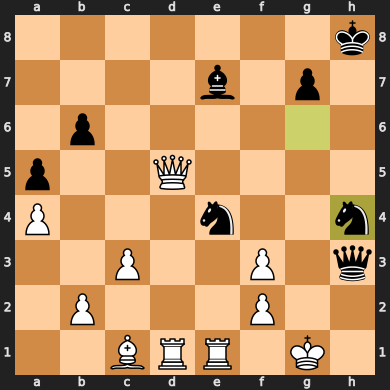

Qh5+


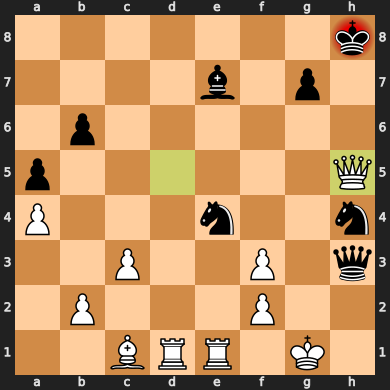

Qxh4


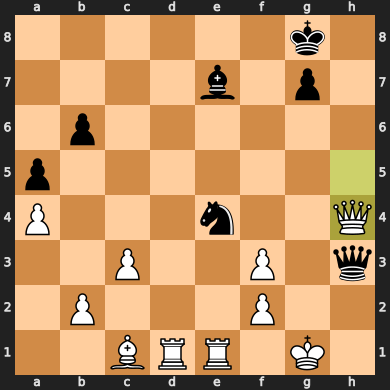

Bxh4


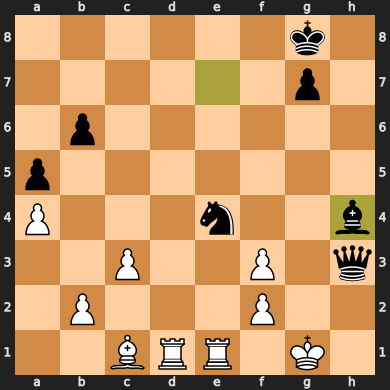

Qg4+


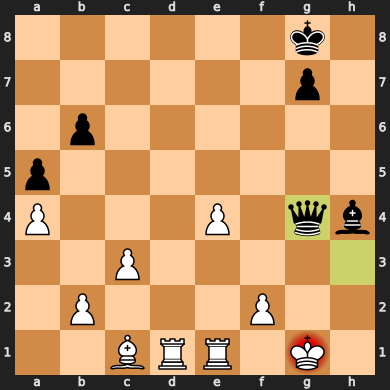

In [9]:
#for move in game.moves:
#    if move.is_threat:
#        print(move.san_notation)
#        display(move.apply_move())